Imports


In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.stats import bootstrap, levene, bartlett
import statsmodels.api as sm
import statsmodels.stats.weightstats as ws
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotnine as p9

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams["pdf.use14corefonts"] = True
# pd.set_option("display.float_format", "{:.4f}".format)

def MAD(x):
    return 1.4826 * np.median(np.abs(x - np.median(x)))


def isoutlier(x, crit=3):
    return np.abs(x - np.median(x)) > crit * MAD(x)


# lm method for apply
def model(df, xname, yname):
    y = df[[yname]].values
    X = df[[xname]].values
    X = X[~np.isnan(y)]
    y = y[~np.isnan(y)]
    X = add_constant(X, True, "add")
    return sm.OLS(y, X).fit()


# predict method for apply
def predict(lm, x):
    return lm.params[0] + x * lm.params[1]


Load data from pickle


In [2]:
df = pd.read_pickle("data.pkl")
display(df)

,block,correct,correctWithoutNoise,demoTrial,earned,error,mass,massNoise,points,size,...,os.name,os.version,os.versionName,timeLimitExceeded,phase,volume,response,consecutive,firstOutlierBlock,pullDuration
0,0,0.05886,0.05886,True,0,0.04114,0.6,0.0,0,"[1536, 864]",...,Windows,NT 10.0,10,NaN,0,0.08,0.1000,False,10,21844.1
1,0,0.03924,0.03924,True,85,-0.00974,0.4,0.0,85,"[1536, 864]",...,Windows,NT 10.0,10,NaN,0,0.06,0.0295,False,10,3573.9
2,0,0.06867,0.06867,True,0,-0.03117,0.7,0.0,85,"[1536, 864]",...,Windows,NT 10.0,10,NaN,0,0.09,0.0375,False,10,4272.2
3,0,0.02943,0.02943,True,100,-0.00143,0.3,0.0,185,"[1536, 864]",...,Windows,NT 10.0,10,NaN,0,0.05,0.0280,False,10,3922.9
4,1,0.03924,0.03924,True,100,-0.00024,0.4,0.0,285,"[1536, 864]",...,Windows,NT 10.0,10,NaN,0,0.06,0.0390,False,10,7108.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24055,19,0.02943,0.02943,False,97,0.00407,0.3,0.0,2663,"[1366, 768]",...,Windows,NT 10.0,10,NaN,1,0.05,0.0335,False,0,4436.9
24056,19,0.05886,0.05886,False,0,-0.05736,0.6,0.0,2760,"[1366, 768]",...,Windows,NT 10.0,10,NaN,1,0.08,0.0015,False,0,10336.5
24057,19,0.06867,0.06867,False,0,-0.04567,0.7,0.0,2760,"[1366, 768]",...,Windows,NT 10.0,10,NaN,1,0.09,0.0230,False,0,9253.7
24058,19,0.07848,0.07848,False,0,-0.06298,0.8,0.0,2760,"[1366, 768]",...,Windows,NT 10.0,10,NaN,1,0.07,0.0155,False,0,1403.0


Single trial exclusions


In [3]:
# Variables to exclude
exclude_vars = list(["response", "error", "x"])

# Exclude consecutive-repeat trials from Frequent Outlier condition
if False:
    df.loc[df["consecutive"], exclude_vars] = np.nan
    print(
        "Excluded %i repeated-target trials in Frequent Outlier."
        % (np.sum(df["consecutive"]))
    )

# Exclude single-trial outliers (N scaled MADs from subject-target median, family only)
if True:
    outlier_thresh = 4
    grouped = df.groupby(["subject", "targetId"])
    df["response_scaled_mad"] = grouped["response"].transform(MAD)
    df["response_median"] = grouped["response"].transform("median")
    thresh = outlier_thresh * df["response_scaled_mad"]
    outlier_trials = (np.abs(df["response"] - df["response_median"]) > thresh) & (
        df["targetId"] != 2
    )
    df.loc[outlier_trials, exclude_vars] = np.nan
    print(
        "Excluded %i outlier trials (%.3g%%)."
        % (
            np.sum(outlier_trials),
            100 * np.sum(outlier_trials) / df[df["targetId"] != 2].shape[0],
        )
    )


Excluded 753 outlier trials (3.69%).


Subject demographics analysis


In [4]:
# Create a dataframe with subject-level data
dfsub = df.drop_duplicates("subject")[
    [
        "subject",
        "condition",
        "workerId",
        "browser.name",
        "browser.version",
        "os.name",
        "os.version",
        "os.versionName",
    ]
]

# Merge in select demographic data from Prolific
dfsub = dfsub.merge(
    pd.read_csv("demographics.csv")
    .query('Status == "APPROVED" & `Completion code` != "Manual Completion"')
    .rename({"Participant id": "workerId"}, axis=1)[
        [
            "workerId",
            "Time taken",
            "Total approvals",
            "Total rejections",
            "Approval rate",
            "Age",
            "Sex",
            "Ethnicity simplified",
            "Country of birth",
            "Country of residence",
            "Nationality",
            "Student status",
            "Employment status",
        ]
    ],
    how="left",
    on="workerId",
)

display(pd.DataFrame(dfsub["Sex"].describe()))
display(pd.DataFrame(dfsub.Age.astype("float").describe()))

dfsub["resolution"] = df.groupby("subject")["size"].min().apply(lambda x: x[0] * x[1])
dfsub["size"] = df.groupby("subject")["size"].min().values
dfsub["sizex"] = dfsub.apply(lambda x: x["size"][0], axis=1)
dfsub["sizey"] = dfsub.apply(lambda x: x["size"][1], axis=1)
dfsub["ar"] = dfsub.apply(lambda x: np.round(x["sizex"] / x["sizey"], 2), axis=1)

# distribution of screen dimensions
display(dfsub[["resolution", "sizex", "sizey", "ar"]].describe())
# Top ten screen dimensions
display(
    dfsub.groupby(["sizex", "sizey"])["subject"]
    .count()
    .reset_index()
    .sort_values("subject", ascending=False)
    .head(10)
)
# Top ten screen aspect ratios
display(
    dfsub.groupby(["ar"])["subject"]
    .count()
    .reset_index()
    .sort_values("subject", ascending=False)
    .head(10)
)


,Sex
count,240
unique,2
top,Male
freq,161


,Age
count,240.000000
mean,37.820833
std,10.428336
min,18.000000
25%,29.000000
50%,37.000000
75%,45.000000
max,60.000000


,resolution,sizex,sizey,ar
count,0.0,240.000000,240.000000,240.000000
mean,NaN,1682.804167,961.383333,1.749250
std,NaN,371.715191,188.094794,0.106096
min,NaN,1080.000000,607.000000,1.330000
25%,NaN,1415.500000,861.500000,1.780000
50%,NaN,1536.000000,900.000000,1.780000
75%,NaN,1920.000000,1080.000000,1.780000
max,NaN,3840.000000,2160.000000,2.390000


,sizex,sizey,subject
38,1920,1080,76
24,1536,864,36
13,1366,768,32
17,1440,900,19
40,2560,1440,9
6,1280,720,9
27,1600,900,6
7,1280,800,5
39,2048,1152,4
30,1680,1050,3


,ar,subject
5,1.78,191
2,1.60,36
1,1.50,4
0,1.33,3
8,2.39,2
3,1.76,1
4,1.77,1
6,1.89,1
7,2.05,1


In [5]:
sel1 =  (df["block"] >= df['firstOutlierBlock']) & (df["block"] > 10) & (df["targetId"] != 2)

# Fit required force X anticipatory force model (family only)
dfsub["rf_af_model"] = (
    df.loc[sel1]
    .groupby("subject")
    .apply(model, xname="correct", yname="response")
    .values
)

# Fit size X anticipatory force model (family only)
dfsub["sz_af_model"] = (
    df.loc[sel1]
    .groupby(["subject"])
    .apply(model, xname="volume", yname="response")
    .values
)

dfsub["intercept"] = dfsub.apply(lambda x: x["sz_af_model"].params[0], axis=1)
dfsub["slope"] = dfsub.apply(lambda x: x["sz_af_model"].params[1], axis=1)

dfsub["family_pred"] = dfsub["sz_af_model"].apply(predict, args=(0.07,))
dfsub["ideal_pred"] = dfsub["sz_af_model"].apply(predict, args=(0.09,))
df = df.merge(
    dfsub[["subject", "family_pred", "ideal_pred"]],
    how="left",
    on="subject",
    suffixes=(None, "_copy"),
)

# Check for outlier participants
dfsub["isoutlier"] = isoutlier(dfsub["family_pred"], crit=5)
print(
    "WARNING: Flagged %i of %i subjects show mean force for family objects > 5 MAD from the median."
    % (np.sum(dfsub["isoutlier"]), dfsub.shape[0])
)
outlier_subjects = dfsub.loc[dfsub["isoutlier"]]["subject"]

if True:
    print(
        "WARNING: Excluded %i of %i subjects (%.3g%%):\nSubjects %s\nConditions %s"
        % (
            np.sum(dfsub["isoutlier"]),
            dfsub.shape[0],
            100 * np.sum(dfsub["isoutlier"]) / dfsub.shape[0],
            [x for x in outlier_subjects],
            [x for x in dfsub.loc[dfsub["isoutlier"], "condition"]],
        )
    )
    print(
        "These excluded subjects account for %i of the %i excluded individual trials"
        % (
            np.sum(outlier_trials & np.isin(df["subject"], outlier_subjects)),
            np.sum(outlier_trials),
        )
    )
    df.drop(df[np.isin(df["subject"], outlier_subjects)].index, inplace=True)
    dfsub.drop(dfsub[np.isin(dfsub["subject"], outlier_subjects)].index, inplace=True)


Subjects ['017', '024']
Conditions ['Small Family', 'Frequent Outlier']
These excluded subjects account for 37 of the 753 excluded individual trials


In [6]:
# Compute outlier mean response and strength of categorical encoding metric
sel0 = (
    (df["block"] > df["firstOutlierBlock"]) & (df["block"] > 10) & (df["targetId"] == 2)
)
dfsub["response"] = df[sel0].groupby("subject")["response"].mean().values
dfsub["dev"] = dfsub["response"] - dfsub["family_pred"]
dfsub["devnorm"] = dfsub["dev"].apply(lambda x: 100 - 100 * x / ((0.3 * 9.81) / 100))


# Rank subjects in each condition based on mean deviation
dfsub["rank"] = dfsub.groupby("condition")["devnorm"].rank(method="dense")

# Merge ranks into main data
df = df.merge(
    dfsub[["subject", "rank"]], how="left", on="subject", suffixes=(None, "_copy")
)

# Compute condition means
dfcond = pd.DataFrame()
dfcond["CE"] = dfsub.groupby("condition")["devnorm"].mean()
dfcond["CE CI"] = dfsub.groupby("condition")["devnorm"].apply(
    lambda x: bootstrap(
        (x,), np.mean, n_resamples=50000, confidence_level=0.68
    ).confidence_interval
)
dfcond = dfcond.sort_values("CE", axis=0, ascending=False).reset_index()
dfcond["lwr"] = dfcond["CE CI"].apply(lambda x: x[0])
dfcond["upr"] = dfcond["CE CI"].apply(lambda x: x[1])
del dfcond["CE CI"]
display(dfcond)

# Re-order conditions by strength of CE
df["condition"] = pd.Categorical(
    values=df["condition"].values,
    categories=dfcond["condition"].values,
    ordered=True,
)
dfsub["condition"] = pd.Categorical(
    values=dfsub["condition"].values,
    categories=dfcond["condition"].values,
    ordered=True,
)
dfcond["condition"] = pd.Categorical(
    values=dfcond["condition"].values,
    categories=dfcond["condition"].values,
    ordered=True,
)


,condition,CE,lwr,upr
0,Nonlinear,98.962496,91.806596,104.227300
1,Concurrent,94.617385,85.928419,100.568610
2,Same Color,89.068816,83.431704,93.791163
3,Similar Colors,87.727850,81.562226,92.300525
4,Added Noise,87.543695,79.509305,93.132110
5,Frequent Outlier,78.273881,68.901918,86.464620
6,One-by-One,75.006313,66.096079,82.558730
7,Nonlinear+,71.546505,63.176609,79.487150
8,Time Pressure,68.374042,59.894340,76.748067
9,Concurrent+,67.142039,57.700278,76.156493


In [7]:
testdata_arr = []
for (cc, ref) in [
    (
        [
            "Small Family",
            "Distinct Colors",
            "Frequent Outlier",
            "Similar Colors",
            "Concurrent",
            "Nonlinear",
        ],
        "Same Color",
    ),
    (
        [
            "Similar Colors",
            "Added Noise",
            "One-by-One",
            "Nonlinear+",
            "Time Pressure",
            "Concurrent+",
        ],
        "Distinct Colors",
    ),
]:
    for c in cc:
        dat1 = dfsub.loc[dfsub["condition"] == c, "devnorm"]
        datref = dfsub.loc[dfsub["condition"] == ref, "devnorm"]
        diff = ws.CompareMeans.from_data(dat1, datref)
        d = np.mean(dat1) - np.mean(datref)
        vartype = "unequal"  # "pooled"
        tt = diff.ttest_ind("larger", usevar=vartype)
        testdata = (
            c,
            ref,
            d,
            diff.std_meandiff_separatevar,
        ) + tt
        testdata_arr.append(testdata)

dfstats = pd.DataFrame(
    testdata_arr,
    columns=[
        "condition",
        "reference",
        "mean_diff",
        "sd_unequal",
        "t",
        "p",
        "df",
    ],
)

for index, row in dfstats.iterrows():
    print(
        "c('%s', '%s', %f, %f, %f),"
        % (
            row["condition"],
            row["reference"],
            row["mean_diff"],
            row["sd_unequal"],
            row["df"],
        )
    )
# output to be copied to bayes_factors.R

c('Small Family', 'Same Color', -45.415213, 10.453145, 29.258044),
c('Distinct Colors', 'Same Color', -29.523347, 10.328037, 31.012086),
c('Frequent Outlier', 'Same Color', -10.794935, 10.496246, 29.157903),
c('Similar Colors', 'Same Color', -1.340966, 7.592791, 37.970154),
c('Concurrent', 'Same Color', 5.548569, 8.967375, 34.801194),
c('Nonlinear', 'Same Color', 9.893680, 8.170131, 37.045113),
c('Similar Colors', 'Distinct Colors', 28.182381, 10.405992, 31.537478),
c('Added Noise', 'Distinct Colors', 27.998227, 11.179091, 35.616324),
c('One-by-One', 'Distinct Colors', 15.460844, 12.248052, 37.910529),
c('Nonlinear+', 'Distinct Colors', 12.001036, 12.194556, 37.873469),
c('Time Pressure', 'Distinct Colors', 8.828573, 12.363513, 37.967878),
c('Concurrent+', 'Distinct Colors', 7.596570, 12.989191, 37.826803),


In [8]:
datsc = dfsub.loc[dfsub["condition"] == "Same Color", "devnorm"]
datnl = dfsub.loc[dfsub["condition"] == "Nonlinear", "devnorm"]
datdc = dfsub.loc[dfsub["condition"] == "Distinct Colors", "devnorm"]
datnll = dfsub.loc[dfsub["condition"] == "Nonlinear+", "devnorm"]

scmean = np.mean(datsc)
datnl -= scmean
datsc -= scmean
dcmean = np.mean(datdc)
datnll -= dcmean
datdc -= dcmean
dat1 = np.concatenate([datnl, datnll])
datref = np.concatenate([datsc, datdc])

diff = ws.CompareMeans.from_data(dat1, datref)
d = np.mean(dat1) - np.mean(datref)
vartype = "unequal"  # "pooled"
tt = diff.ttest_ind("larger", usevar=vartype)
print("mean = %f\nsd = %f\ndf = %f" % (d, diff.std_meandiff_separatevar, tt[2]))

# output to be copied to bayes_factors.R

mean = 10.947358
sd = 7.246508
df = 77.991591


In [9]:
# Get LM predictions of the size X AF model (over the desired plotting range)
prednum = 50
predx = np.linspace(0.05, 0.09, num=prednum)
exog = add_constant(predx, True, "add")
dflmpred = pd.DataFrame(
    {
        "predy": np.concatenate(
            dfsub.apply(
                lambda x: x["sz_af_model"].get_prediction(exog).predicted_mean, axis=1
            ).values
        ),
        "predx": np.tile(predx, dfsub["subject"].nunique()),
        "subject": np.repeat(np.unique(dfsub["subject"]), prednum),
        "condition": np.repeat(dfsub["condition"].values, prednum),
    }
)
# Merge in the ranks
dflmpred = dflmpred.merge(
    dfsub[["subject", "rank"]], how="left", on="subject", suffixes=(None, "_copy")
)


In [10]:
# Same as above for the pre-outlier size X AF model
dfsub["sz_af_model_early"] = (
    df.loc[(df["block"] < 11) & (df["block"] > 5) & (df["targetId"] != 2)]
    .groupby(["subject"])
    .apply(model, xname="volume", yname="response")
    .values
)
prednum = 50
predx = np.linspace(0.05, 0.09, num=prednum)
exog = add_constant(predx, True, "add")
dflmpred_early = pd.DataFrame(
    {
        "predy": np.concatenate(
            dfsub.apply(
                lambda x: x["sz_af_model_early"].get_prediction(exog).predicted_mean, axis=1
            ).values
        ),
        "predx": np.tile(predx, dfsub["subject"].nunique()),
        "subject": np.repeat(np.unique(dfsub["subject"]), prednum),
        "condition": np.repeat(dfsub["condition"].values, prednum),
    }
)
# Merge in the ranks
dflmpred_early = dflmpred_early.merge(
    dfsub[["subject", "rank"]], how="left", on="subject", suffixes=(None, "_copy")
)

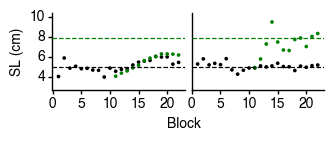

In [11]:
# Same Color condition example participant
lol = df[(df["condition"] == "Same Color") & (df["targetId"] != 2) & (df["rank"] == 10)]
lol.condition.cat.remove_unused_categories(inplace=True)
lol = lol.groupby(["rank", "block"])[["block", "response"]].mean()
lol = (
    lol.groupby("rank").rolling(window=1, on="block", center=True, min_periods=1).mean()
)
lol = lol.rename_axis(["rank", "rank2", "block"]).reset_index()

lmao = df[
    (df["condition"] == "Same Color") & (df["targetId"] == 2) & (df["rank"] == 10)
]
lmao.condition.cat.remove_unused_categories(inplace=True)
lmao = lmao.groupby(["rank", "block"])[["block", "response"]].mean()
lmao = (
    lmao.groupby("rank")
    .rolling(window=5, on="block", center=True, min_periods=1)
    .mean()
)
lmao = lmao.rename_axis(["rank", "rank2", "block"]).reset_index()
lol["condition"] = "Same Color"
lmao["condition"] = "Same Color"

# Distinct Colors condition example participant
lol1 = df[
    (df["condition"] == "Distinct Colors") & (df["targetId"] != 2) & (df["rank"] == 3)
]
lol1.condition.cat.remove_unused_categories(inplace=True)
lol1 = lol1.groupby(["rank", "block"])[["block", "response"]].mean()
lol1 = (
    lol1.groupby("rank")
    .rolling(window=1, on="block", center=True, min_periods=1)
    .mean()
)
lol1 = lol1.rename_axis(["rank", "rank2", "block"]).reset_index()

lmao1 = df[
    (df["condition"] == "Distinct Colors") & (df["targetId"] == 2) & (df["rank"] == 3)
]
lmao1.condition.cat.remove_unused_categories(inplace=True)
lmao1 = lmao1.groupby(["rank", "block"])[["block", "response"]].mean()
lmao1 = (
    lmao1.groupby("rank")
    .rolling(window=1, on="block", center=True, min_periods=1)
    .mean()
)
lmao1 = lmao1.rename_axis(["rank", "rank2", "block"]).reset_index()
lol1["condition"] = "Distinct Colors"
lmao1["condition"] = "Distinct Colors"

# Combine and plot
lol = pd.concat([lol, lol1])
lmao = pd.concat([lmao, lmao1])
lol["block"] = lol["block"] + 1
lmao["block"] = lmao["block"] + 1
lmao.condition = pd.Categorical(lmao.condition,lmao.condition.unique(),ordered=True)
lol.condition = pd.Categorical(lol.condition,lol.condition.unique(),ordered=True)
lmao.response *= 100
lol.response *= 100
p = (
    p9.ggplot()
    + p9.geom_point(p9.aes("block", "response"), data=lol, stroke=0)
    + p9.geom_point(p9.aes("block", "response"), color="green", data=lmao, stroke=0)
    + p9.geom_hline(yintercept=5 * 0.981, linetype="dashed", size=0.5)
    + p9.geom_hline(yintercept=8 * 0.981, linetype="dashed", color="green", size=0.5)
    + p9.scale_y_continuous(breaks=[4,6,8,10], limits=[3,10])
    + p9.labels.labs(x="Block", y="SL (cm)")
    + p9.facet_grid(
        ". ~ condition",
    )
    + p9.theme_classic(base_family="Helvetica")
    + p9.theme(
        legend_position="none",
        figure_size=(3.5, 1),
        strip_background=p9.element_blank(),
        strip_text_x=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text = p9.element_text(size = 10,color='black')
    )
)
fig = p.draw(show=True)
#p.save('examples_timeline.pdf')

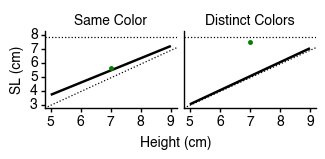

In [12]:
# Same Color condition example participant
dflmSC = dflmpred[(dflmpred["condition"] == "Same Color") & (dflmpred["rank"] == 10)]
dflmSC.condition.cat.remove_unused_categories(inplace=True)
dfsubSC = dfsub[(dfsub["condition"] == "Same Color") & (dfsub["rank"] == 10)]
dfsubSC.condition.cat.remove_unused_categories(inplace=True)

# Distinct Colors condition example participant
dflmDC = dflmpred[(dflmpred["condition"] == "Distinct Colors") & (dflmpred["rank"] == 3)]
dflmDC.condition.cat.remove_unused_categories(inplace=True)
dfsubDC = dfsub[(dfsub["condition"] == "Distinct Colors") & (dfsub["rank"] == 3)]
dfsubDC.condition.cat.remove_unused_categories(inplace=True)

dfsub_both = pd.concat([dfsubSC,dfsubDC])
dflm_both = pd.concat([dflmSC,dflmDC])
dfsub_both.condition = pd.Categorical(dfsub_both.condition, dfsub_both.condition.unique(), ordered=True)
dflm_both.condition = pd.Categorical(dflm_both.condition, dflm_both.condition.unique(), ordered=True)

dflm_both.predx *= 100
dflm_both.predy *= 100
dfsub_both.response *= 100

p = (
    p9.ggplot()
    + p9.geom_line(
        p9.aes("predx", "predy"),
        data=dflm_both,
        size=1,
    )
    + p9.stat_summary(
        p9.aes(x= 7, y="response"), data=dfsub_both, color='green', geom='point', stroke=0, size=2
    )
    + p9.geom_abline(slope= 0.981, intercept= -2*.981, linetype="dotted", size=0.5)
    + p9.geom_hline(yintercept= 0.8 * 9.81, linetype="dotted", size=0.5)
    + p9.scale_y_continuous(breaks=[3,4,5,6,7,8], limits=[3,8])
    + p9.labels.labs(x="Height (cm)", y="SL (cm)")
    + p9.facet_grid(
        ". ~ condition",
    )
    + p9.theme_classic(base_family='Helvetica')
    + p9.theme(
        legend_position="none",
        figure_size=(3.5, 1),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=10, color="black"),
    )
)
fig = p.draw(show=True)
#p.save('examples_summary.pdf')

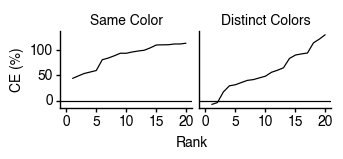

In [13]:
# Learning by subject
p = (
    p9.ggplot(
        p9.aes("rank", "devnorm"),
        dfsub[np.isin(dfsub["condition"], ["Same Color", "Distinct Colors"])],
    )
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
    + p9.labels.labs(x="Rank", y="CE (%)")
    + p9.scale_x_continuous(breaks=[0,5,10,15,20], limits=[0,20])
    + p9.facet_wrap("~ condition", dir="h")
    + p9.theme_classic(base_family='Helvetica')
    + p9.theme(
        legend_position="none",
        figure_size=(3.5, 1),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=10, color="black"),
    )
)
fig = p.draw(show=True)
#p.save("example_individuals.pdf")


In [14]:
dfcond["slope"] = dfsub.groupby("condition")["slope"].mean().values
dfcond["slope CI"] = dfsub.groupby("condition")["slope"].apply(
    lambda x: bootstrap(
        (x,), np.mean, n_resamples=50000, confidence_level=0.68
    ).confidence_interval
).values
dfcond["slopelwr"] = dfcond["slope CI"].apply(lambda x: x[0])
dfcond["slopeupr"] = dfcond["slope CI"].apply(lambda x: x[1])

dfcond["intercept"] = dfsub.groupby("condition")["intercept"].mean().values
dfcond["intercept CI"] = dfsub.groupby("condition")["intercept"].apply(
    lambda x: bootstrap(
        (x,), np.mean, n_resamples=50000, confidence_level=0.68
    ).confidence_interval
).values
dfcond["interceptlwr"] = dfcond["intercept CI"].apply(lambda x: x[0])
dfcond["interceptupr"] = dfcond["intercept CI"].apply(lambda x: x[1])


/var/folders/b9/s2l8_fb57r342xkv9n1f5_bh0000gn/T/ipykernel_13900/2956101136.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/b9/s2l8_fb57r342xkv9n1f5_bh0000gn/T/ipykernel_13900/2956101136.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/b9/s2l8_fb57r342xkv9n1f5_bh0000gn/T/ipykernel_13900/2956101136.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

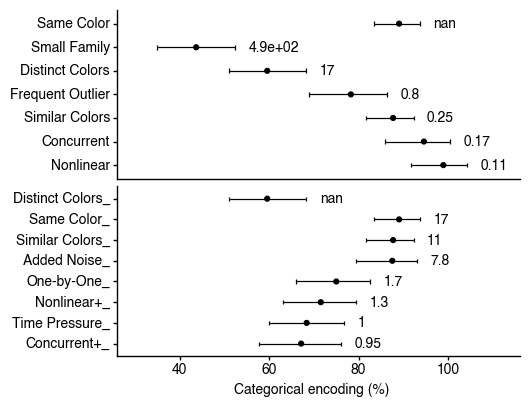

In [15]:
dfcondw = dfcond.loc[
    np.isin(
        dfcond["condition"],
        [
            "Same Color",
            "Distinct Colors",
            "Similar Colors",
            "Small Family",
            "Frequent Outlier",
            "Nonlinear",
            "Concurrent",
        ],
    )
]
dfcondw["group"] = "1. weaken"

dfconds = dfcond.loc[
    np.isin(
        dfcond["condition"],
        [
            "Same Color",
            "Similar Colors",
            "Time Pressure",
            "One-by-One",
            "Added Noise",
            "Nonlinear+",
            "Concurrent+",
            "Distinct Colors",
        ],
    )
]
dfconds["condition"] = dfconds["condition"].apply(lambda x: x + "_")
dfconds["group"] = "2. strengthen"
dfconds.sort_values("CE", axis=0, ascending=True)["condition"]

dfcond_both = pd.concat([dfcondw, dfconds])

wcond_order = dfcondw.sort_values("CE", axis=0, ascending=False)["condition"]
wcond_order.pop(2)  # .values[1:],'Same Color')
wcond_order = np.append(wcond_order, "Same Color")
scond_order = np.append(
    dfconds.sort_values("CE", axis=0, ascending=True)["condition"].values[1:],
    "Distinct Colors_",
)
cond_order = np.append(wcond_order, scond_order)


dfcond_both["condition"] = pd.Categorical(
    values=dfcond_both["condition"],
    categories=np.append(cond_order[cond_order != "Same Color"], "Same Color"),
    ordered=True,
)

# Copied and slightly modified from R output
dfcond_both.loc[dfcond_both["condition"] == "Nonlinear", "bf"] = 0.114743428101051
dfcond_both.loc[dfcond_both["condition"] == "Concurrent", "bf"] = 0.167772481948281
dfcond_both.loc[dfcond_both["condition"] == "Similar Colors", "bf"] = 0.248722354974698
dfcond_both.loc[
    dfcond_both["condition"] == "Frequent Outlier", "bf"
] = 0.796860198941538
dfcond_both.loc[dfcond_both["condition"] == "Distinct Colors", "bf"] = 17.330974217091
dfcond_both.loc[dfcond_both["condition"] == "Small Family", "bf"] = 494.924183289324

dfcond_both.loc[dfcond_both["condition"] == "Same Color_", "bf"] = 17.330974217091
dfcond_both.loc[dfcond_both["condition"] == "Similar Colors_", "bf"] = 10.8016203159479
dfcond_both.loc[dfcond_both["condition"] == "Added Noise_", "bf"] = 7.75659753081867
dfcond_both.loc[dfcond_both["condition"] == "One-by-One_", "bf"] = 1.6983162897922
dfcond_both.loc[dfcond_both["condition"] == "Nonlinear+_", "bf"] = 1.30204570201336
dfcond_both.loc[dfcond_both["condition"] == "Time Pressure_", "bf"] = 1.03520542355158
dfcond_both.loc[dfcond_both["condition"] == "Concurrent+_", "bf"] = 0.952844779654763

p = (
    p9.ggplot(p9.aes(x="condition", y="CE"), dfcond_both)
    + p9.geom_point(p9.aes(y="CE"))
    + p9.geom_errorbar(p9.aes(y="CE", ymin="lwr", ymax="upr"), width=0.2)
    + p9.geom_text(
        p9.aes(y="upr", label="bf"),
        nudge_y=3,
        format_string="{:.2g}",
        ha="left",
        size=10
    )
    + p9.scale_y_continuous(breaks=[40, 60, 80, 100], limits=[30, 112])
    + p9.facet_grid("group ~ .", scales="free_y", space="free")
    + p9.coord_flip()
    + p9.labels.labs(y = 'Categorical encoding (%)', x = '')
    + p9.theme_classic(base_family="Helvetica")
    + p9.theme(
        legend_position="none",
        figure_size=(5.2, 4.5),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text = p9.element_text(size = 10,color='black')
    )
)
fig = p.draw(show=True)
#p.save("categorical_encoding.pdf")


In [16]:

sel1 =  (df["block"] >= df['firstOutlierBlock']) & (df["block"] > 10)
sel2 =  (df["block"] < df['firstOutlierBlock']) & (df["block"] > 5)
dfsubobj = df[sel1].groupby(["subject","condition","volume","rank"],observed=True)[["correct","response"]].mean().reset_index()
dfsubobj2 = df[sel2].groupby(["subject","condition","volume","rank"],observed=True)[["correct","response"]].mean().reset_index()


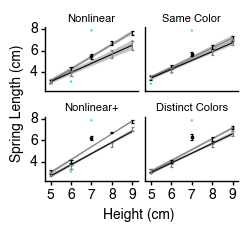

In [17]:
# Plot condition summaries
dflmpred["PredX"] = dflmpred["predx"]*100
dflmpred["PredY"] = dflmpred["predy"]*100
dflmpred_early["PredX"] = dflmpred_early["predx"]*100
dflmpred_early["PredY"] = dflmpred_early["predy"]*100
dfsubobj["Volume"] = dfsubobj["volume"]*100
dfsubobj["Correct"] = dfsubobj["correct"]*100
dfsubobj["Response"] = dfsubobj["response"]*100
dfsubobj2["Volume"] = dfsubobj2["volume"]*100
dfsubobj2["Correct"] = dfsubobj2["correct"]*100
dfsubobj2["Response"] = dfsubobj2["response"]*100
conds = dfsub['condition'].unique()
conds = ["Same Color", "Distinct Colors", "Nonlinear", "Nonlinear+"]
p = (
    p9.ggplot()
    + p9.stat_summary(
        p9.aes(x="Volume", y="Correct"),
        data=dfsubobj[np.isin(dfsubobj["condition"], conds)],
        geom='point',
        stroke = 0,
        size = 1,
        color='turquoise'
    )
    + p9.stat_summary(
        p9.aes("PredX", "PredY"),
        data=dflmpred[np.isin(dflmpred["condition"], conds)],
        geom="line",
        fun_data="mean_cl_normal",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        size=0.5,
        color='darkgray'
    )
    + p9.stat_summary(
        p9.aes("PredX", "PredY"),
        data=dflmpred[np.isin(dflmpred["condition"], conds)],
        geom="ribbon",
        fun_data="mean_cl_normal",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        alpha=0.3,
    )
    + p9.stat_summary(
        p9.aes("PredX", "PredY"),
        data=dflmpred_early[np.isin(dflmpred_early["condition"], conds)],
        geom="line",
        fun_data="mean_cl_normal",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        size=0.5,
        color='black'
    )
    + p9.stat_summary(
        p9.aes("PredX", "PredY"),
        data=dflmpred_early[np.isin(dflmpred_early["condition"], conds)],
        geom="ribbon",
        fun_data="mean_cl_normal",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        alpha=0.3,
    )
    + p9.stat_summary(
        p9.aes(x="Volume", y="Response"),
        data=dfsubobj[np.isin(dfsubobj["condition"], conds)],
        fun_data="mean_cl_boot",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        geom='errorbar',
        width=0.15
    )
    + p9.stat_summary(
        p9.aes(x="Volume", y="Response"),
        data=dfsubobj[np.isin(dfsubobj["condition"], conds) & (dfsubobj["volume"]==0.07)],
        fun_data="mean_cl_boot",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        geom='point',
        stroke = 0
    )
    + p9.stat_summary(
        p9.aes(x="Volume", y="Response"),
        data=dfsubobj2[np.isin(dfsubobj2["condition"], conds)],
        fun_data="mean_cl_boot",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        geom='errorbar',
        width=0.15,
        color = 'gray'
    )
    + p9.stat_summary(
        p9.aes(x="Volume", y="Response"),
        data=dfsubobj2[np.isin(dfsubobj2["condition"], conds) & (dfsubobj2["volume"]==0.07)],
        fun_data="mean_cl_boot",
        fun_args={"n_samples":50000, "confidence_interval":0.68},
        geom='point',
        stroke = 0,
        color = 'gray'
    )
    + p9.labels.labs(x="Height (cm)", y="Spring Length (cm)")
    + p9.facet_wrap("~ condition",ncol=2,dir='h')
    + p9.theme_classic(base_family="Helvetica")
    + p9.scale_y_continuous(breaks=[4,6,8])
    + p9.theme(
        legend_position="none",
        figure_size=(2.5, 2),
        strip_background=p9.element_blank(),
        strip_text_x=p9.element_text(size=8, color="black"),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=10, color="black"),
    )
)
fig = p.draw(show=True)
#p.save('select_summaries.pdf')
# Note: PlotnineWarning about removed rows is okay, it's the HighFreq repeats we excluded


In [18]:
# Difference in slope between Nonlinears combined and references combined
diff = ws.CompareMeans.from_data(
    dfsub.loc[(dfsub["condition"] == 'Nonlinear') | (dfsub["condition"] == 'Nonlinear+'), "slope"],
    dfsub.loc[(dfsub["condition"] == 'Same Color') | (dfsub["condition"] == 'Distinct Colors'), "slope"],
)
d = np.mean(dfsub.loc[(dfsub["condition"] == 'Nonlinear') | (dfsub["condition"] == 'Nonlinear+'), "slope"]) - np.mean(
    dfsub.loc[(dfsub["condition"] == 'Same Color') | (dfsub["condition"] == 'Distinct Colors'), "slope"]
)
vartype = "unequal"  # "pooled"
tt = diff.ttest_ind(usevar=vartype)
print(
    "c('%s', '%s', %f, %f, %f)," % ('Nonlinears', 'Refs', d, diff.std_meandiff_separatevar, tt[2])
)
print(diff.tconfint_diff(usevar=vartype))


c('Nonlinears', 'Refs', 0.204298, 0.056841, 77.427495),
(0.0911237906376449, 0.31747221412019516)


In [19]:
# R-squareds for the family regression in all conditions (i.e., linearity analysis)
dfsub['sz_af_rsq'] = dfsub.apply(lambda x: x['sz_af_model'].rsquared, axis=1)
dfsub['condition_comb'] = dfsub['condition']
dfsub['condition_comb'].map({'Nonlinear+':'Nonlinear', 'Distinct Colors':'Same Color'})
# print(dfsub.groupby('condition')['sz_af_rsq'].mean())
# dfsub.groupby('condition')['sz_af_rsq'].apply(lambda x: bootstrap((x,),np.mean,n_resamples=50000).confidence_interval)
dfsub['condition_comb'] = dfsub['condition']
dfsub.loc[dfsub['condition']=='Distinct Colors','condition_comb'] = 'Same Color'
dfsub.loc[dfsub['condition']=='Nonlinear+','condition_comb'] = 'Nonlinear'
print(dfsub.groupby('condition_comb')['sz_af_rsq'].mean())
dfsub[np.isin(dfsub['condition_comb'],['Same Color','Nonlinear'])].groupby('condition_comb',observed=True)['sz_af_rsq'].apply(lambda x: bootstrap((x,),np.mean,n_resamples=50000).confidence_interval)

condition_comb
Nonlinear           0.788797
Concurrent          0.765059
Same Color          0.730859
Similar Colors      0.584727
Added Noise         0.647547
Frequent Outlier    0.589133
One-by-One          0.711631
Nonlinear+               NaN
Time Pressure       0.669549
Concurrent+         0.703594
Distinct Colors          NaN
Small Family        0.471909
Name: sz_af_rsq, dtype: float64


condition_comb
Nonlinear     (0.7286676783259145, 0.8272622785977939)
Same Color    (0.6464521454398529, 0.7871530324647201)
Name: sz_af_rsq, dtype: object